In [31]:
 # --- 配置路径 (请根据你的实际文件名修改) ---
BAM_FILE = "/data/work/human_brain/710_68_1_humanbrain_251209_NB.duplicates.directional.bam"  # 68_1 UMI去重bam
GTF_FILE = "/data/work/human_brain/genes.gtf"
FASTA_FILE = "/data/work/human_brain/genome.fasta"
DB_FILE = "/data/work/hg38_annotations.db" # 运行后生成的数据库缓存

In [2]:
import gffutils
import os

def load_or_create_gtf_db(gtf_path, db_path, force_rebuild=False):
    """
    加载已有的 GTF 数据库，如果不存在则创建一个。
    
    参数:
    - gtf_path: 原始 GTF 文件路径
    - db_path: 生成的 SQLite 数据库存储路径
    - force_rebuild: 是否强制删除旧数据库重新构建 (默认 False)
    """
    
    # 1. 检查是否需要重新构建
    if force_rebuild and os.path.exists(db_path):
        print(f"提示：正在删除旧数据库以重新构建: {db_path}")
        os.remove(db_path)

    # 2. 如果数据库已存在，直接加载
    if os.path.exists(db_path):
        print(f"--- 正在加载现有数据库: {db_path} ---")
        # 直接连接现有的数据库文件
        db = gffutils.FeatureDB(db_path)
    else:
        # 3. 如果数据库不存在，启动构建流程
        print(f"--- 首次运行：正在解析 GTF 并创建数据库 ---")
        print(f"源文件: {gtf_path}")
        print("提示：此过程通常需要 5-20 分钟，请耐心等待...")
        
        try:
            db = gffutils.create_db(
                gtf_path, 
                db_path, 
                force=True, 
                keep_order=True,
                # 基因组级别分析建议禁用推测，以加快速度
                disable_infer_genes=True, 
                disable_infer_transcripts=True,
                verbose=True  # 实时显示处理行数
            )
            print("--- 数据库构建成功并已加载！ ---")
        except Exception as e:
            print(f"错误：构建数据库失败。原因: {e}")
            if os.path.exists(db_path):
                os.remove(db_path) # 清理半成品
            return None
            
    return db

# --- 使用方法示例 ---
# GTF_FILE = "genes.gtf"
# DB_FILE = "hg38_annotations.db"

# 1. 正常加载
# db = load_or_create_gtf_db(GTF_FILE, DB_FILE)

# 2. 如果你更换了参考基因组或发现之前的数据库有问题，可以强制刷新：
# db = load_or_create_gtf_db(GTF_FILE, DB_FILE, force_rebuild=True)

In [3]:
db = load_or_create_gtf_db(GTF_FILE, DB_FILE)

--- 正在加载现有数据库: /data/work/hg38_annotations.db ---


In [15]:
import pysam
import pandas as pd
import gffutils
import matplotlib.pyplot as plt
from intervaltree import IntervalTree

def get_precise_capture_site(read):
    # <--- 新增：CIGAR 字符串解析捕获位点
    """
    根据 CIGAR 字符串解析出最后一个真正匹配 (M/=/X) 的基因组坐标
    返回该位点所在的 M/=/X 块的长度 (m_length)
    """
    # 获取 CIGAR 元组，如果为空则返回默认值
    cigars = read.cigartuples
    if not cigars:
        return (read.reference_start, 0)
    
    if not read.is_reverse:
        # 正向链 (+): 寻找最后一个匹配碱基的末端坐标
        curr_ref_pos = read.reference_start
        last_match_end = read.reference_start
        last_m_len = 0
        if cigars:
            for op, length in cigars:
                if op in (0, 2, 7, 8): # M, D, =, X (消耗参考基因组坐标)
                    curr_ref_pos += length
                    if op != 2: # 只有 M, =, X 是真实匹配，D 是缺失
                        last_match_end = curr_ref_pos
                        last_m_len = length
                elif op == 3: # N (跨越内含子，消耗坐标)
                    curr_ref_pos += length
        return last_match_end, last_m_len
    else:
        # 反向链 (-): 寻找第一个匹配碱基的起始坐标
        curr_ref_pos = read.reference_start
        first_m_len = 0
        if cigars:
            for op, length in cigars:
                if op in (0, 7, 8): # 找到第一个真正的匹配块 (M, =, X)
                    first_m_len = length
                    return curr_ref_pos, first_m_len
                if op in (2, 3): # D, N 消耗坐标
                    curr_ref_pos += length
        return read.reference_start,0

In [20]:
def analyze_capture_full_details_v2(bam_path, db, wobble=15):
    # --- 步骤 1: 构建内存基因结构索引 ---
    print(f"--- 步骤 1: 构建基因索引 (Wobble Window: ±{wobble}bp) ---")
    gene_index = {}
    gene_structures = {} 

    for gene in db.features_of_type('gene'):
        chrom = gene.chrom
        strand = gene.strand
        g_id = gene.id
        g_name = gene.attributes.get('gene_name', [g_id])[0]
        
        if chrom not in gene_index:
            gene_index[chrom] = IntervalTree()
        
        gene_index[chrom].addi(gene.start, gene.end, g_id)
        
        last_exons = set()
        all_exons = set() 
        
        for tx in db.children(gene, featuretype='transcript'):
            exons = sorted(list(db.children(tx, featuretype='exon')), key=lambda e: e.start)
            if not exons: continue
        
            target_last = exons[-1] if strand == '+' else exons[0]
            last_exons.add((target_last.start, target_last.end))
            
            for e in exons:
                all_exons.add((e.start, e.end))
        
        gene_structures[g_id] = {
            'name': g_name,
            'strand': strand,
            'last_exons': last_exons,
            'all_exons': all_exons,
            'g_range': (gene.start, gene.end)
        }

    # --- 步骤 2: 扫描 BAM ---
    print("--- 步骤 2: 扫描 BAM 并解析 CIGAR ---")
    bf = pysam.AlignmentFile(bam_path, "rb")
    results_list = []
    
    counts = {"Last Exon": 0, "Internal Exon": 0, "Intron": 0, "Other": 0}
    total_primary = 0

    for read in bf.fetch(until_eof=True):
        # 过滤非主要比对
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
            
        total_primary += 1
        
        
        # 检索该 Read 所在的基因区间
        chrom = read.reference_name
        r_start = read.reference_start
        r_end = read.reference_end
        matches = gene_index.get(chrom, IntervalTree()).overlap(r_start, r_end)
        if not matches:
            counts["Other"] += 1
            continue
            
        g_id = list(matches)[0].data
        struct = gene_structures[g_id]
        strand, (g_s, g_e) = struct['strand'], struct['g_range']
        
        # 1. 定义捕获位点 (Capture Site)<--- 新增: CIGAR解析捕获位点
        capture_site, terminal_m_len = get_precise_capture_site(read)
        
        # 2. 计算相对位置
        if (g_e - g_s) != 0:
            rel_pos = (capture_site - g_s) / (g_e - g_s) if strand == '+' else (g_e - capture_site) / (g_e - g_s)
        else:
            rel_pos = 0
        rel_pos = max(0, min(1, rel_pos))

        # 4. 判定捕获点落在什么位置 <--- 新增: 增加 Wobble Window
        location = "Intron"
        is_matched = False
        
        # 末端外显子
        for s, e in struct['last_exons']:
            if (s - wobble) <= capture_site <= (e + wobble):
                location = "Last Exon"
                counts["Last Exon"] += 1
                found = True
                break
        
        # 其他外显子
        if not is_matched:
            for s, e in struct['all_exons']:
                if (s - wobble) <= capture_site <= (e + wobble):
                    location = "Internal Exon"
                    counts["Internal Exon"] += 1
                    found = True
                    break
        # 内含子
        if not is_matched:
            counts["Intron"] += 1
        
        # --- 结果记录：供后续几何分析使用 ---
        results_list.append({
            'read_name': read.query_name,     
            'chrom': chrom,                   
            'capture_site': capture_site,     # <--- 新增：全长 Read 的捕获位点
            'terminal_m_len': terminal_m_len, 
            'gene_id': g_id,                  
            'rel_pos': rel_pos,               
            'location': location,  
            'read_start': r_start,            # 用于检验比对坐标是否和CIGAR捕获位点一致
            'read_end': r_end
        })

        if total_primary % 500000 == 0:
            print(f"已处理 {total_primary} 条 Reads...")

    bf.close()
    
    # --- 步骤 3: 汇总报告 ---
    print("\n" + "="*40)
    print("捕获位点分布统计报告")
    print("-" * 40)
    valid_total = total_primary - counts["Other"]
    for category in ["Last Exon", "Internal Exon", "Intron"]:
        count = counts[category]
        percentage = (count / valid_total) * 100 if valid_total > 0 else 0
        print(f"{category:15s}: {count:10d} ({percentage:.2f}%)")
    print(f"{'Other/Intergenic':15s}: {counts['Other']:10d}")
    print("="*40)
    
    return pd.DataFrame(results_list)

In [21]:
df_results = analyze_capture_full_details_v2(BAM_FILE, db, wobble=15)

--- 步骤 1: 构建基因索引 (Wobble Window: ±15bp) ---
--- 步骤 2: 扫描 BAM 并解析 CIGAR ---
已处理 500000 条 Reads...
已处理 1000000 条 Reads...
已处理 1500000 条 Reads...
已处理 2000000 条 Reads...
已处理 2500000 条 Reads...
已处理 3000000 条 Reads...
已处理 3500000 条 Reads...
已处理 4000000 条 Reads...
已处理 4500000 条 Reads...
已处理 5000000 条 Reads...
已处理 5500000 条 Reads...
已处理 6000000 条 Reads...
已处理 6500000 条 Reads...
已处理 7000000 条 Reads...
已处理 7500000 条 Reads...

捕获位点分布统计报告
----------------------------------------
Last Exon      :    1357321 (17.71%)
Internal Exon  :    1056034 (13.78%)
Intron         :    5248789 (68.50%)
Other/Intergenic:          0


In [29]:
def analyze_capture_by_tag(bam_path, db, wobble=15):
    # --- 步骤 1: 建立 ID 映射字典 (极速) ---
    print("--- 步骤 1: 构建基因结构字典 ---")
    gene_structures = {}
    for gene in db.features_of_type('gene'):
        g_id = gene.id  # 确保这里的 ID 能匹配上 ENSG00000241599 这种格式
        
        # 提取该基因所有的末端外显子和全部外显子
        last_exons = set()
        all_exons = set()
        for tx in db.children(gene, featuretype='transcript'):
            exons = sorted(list(db.children(tx, featuretype='exon')), key=lambda e: e.start)
            if not exons: continue
            target_last = exons[-1] if gene.strand == '+' else exons[0]
            last_exons.add((target_last.start, target_last.end))
            for e in exons:
                all_exons.add((e.start, e.end))
        
        gene_structures[g_id] = {
            'strand': gene.strand,
            'last_exons': last_exons,
            'all_exons': all_exons,
            'g_range': (gene.start, gene.end)
        }

    # --- 步骤 2: 遍历 BAM，直接通过 GX 标签获取结构 ---
    print("--- 步骤 2: 开始扫描 BAM 并提取坐标 ---")
    bf = pysam.AlignmentFile(bam_path, "rb")
    results_list = []
    counts = {"Last Exon": 0, "Internal Exon": 0, "Intron": 0, "Other": 0}

    
    total_primary = 0
    
    for read in bf.fetch(until_eof=True):
        total_primary += 1
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        
        
        # 1. 直接获取 Gene ID <--- 新增: 用bam文件中的基因注释
        try:
            gx_id = read.get_tag('GX')
        except KeyError:
            counts["Other"] += 1
            continue
        
        # 2. 如果数据库里没有这个基因，跳过
        if gx_id not in gene_structures:
            counts["Other"] += 1
            continue
            
        struct = gene_structures[gx_id]
        
        # 3. 解析精确捕获位点
        capture_site, terminal_m_len = get_precise_capture_site(read)
        
        # 4. 基于该基因结构的逻辑判定 (带 Wobble)
        location = "Intron"
        is_matched = False 
        
        # 优先判定 Last Exon
        for s, e in struct['last_exons']:
            if (s - wobble) <= capture_site <= (e + wobble):
                location = "Last Exon"
                counts["Last Exon"] += 1
                is_matched = True
                break
        
        if not is_matched:
            for s, e in struct['all_exons']:
                if (s - wobble) <= capture_site <= (e + wobble):
                    location = "Internal Exon"
                    counts["Internal Exon"] += 1
                    is_matched = True
                    break
        
        if not is_matched:
            counts["Intron"] += 1
        
        # 记录详细信息供后续分析
        results_list.append({
            'read_name': read.query_name,
            'gene_id': gx_id,
            'capture_site': capture_site,
            'location': location,
            'terminal_m_len': terminal_m_len,
            'preassigned_re': read.get_tag('RE') if read.has_tag('RE') else None
        })
        
        if total_primary % 500000 == 0:
            print(f"已处理 {total_primary} 条 Reads...")

    bf.close()
    # --- 步骤 3: 汇总报告 ---
    print("\n" + "="*40)
    print("捕获位点分布统计报告")
    print("-" * 40)
    valid_total = total_primary - counts["Other"]
    for category in ["Last Exon", "Internal Exon", "Intron"]:
        count = counts[category]
        percentage = (count / valid_total) * 100 if valid_total > 0 else 0
        print(f"{category:15s}: {count:10d} ({percentage:.2f}%)")
    print(f"{'Other/Intergenic':15s}: {counts['Other']:10d}")
    print("="*40)
   
    return pd.DataFrame(results_list)

In [30]:
df_results_v2 = analyze_capture_by_tag(BAM_FILE, db, wobble=15)

--- 步骤 1: 构建基因结构字典 ---
--- 步骤 2: 开始扫描 BAM 并提取坐标 ---
已处理 500000 条 Reads...
已处理 1000000 条 Reads...
已处理 1500000 条 Reads...
已处理 2000000 条 Reads...
已处理 2500000 条 Reads...
已处理 3000000 条 Reads...
已处理 3500000 条 Reads...
已处理 4000000 条 Reads...
已处理 4500000 条 Reads...
已处理 5000000 条 Reads...
已处理 5500000 条 Reads...
已处理 6000000 条 Reads...
已处理 7000000 条 Reads...
已处理 7500000 条 Reads...

捕获位点分布统计报告
----------------------------------------
Last Exon      :    1436535 (19.68%)
Internal Exon  :    1157766 (15.86%)
Intron         :    4704751 (64.46%)
Other/Intergenic:     363092


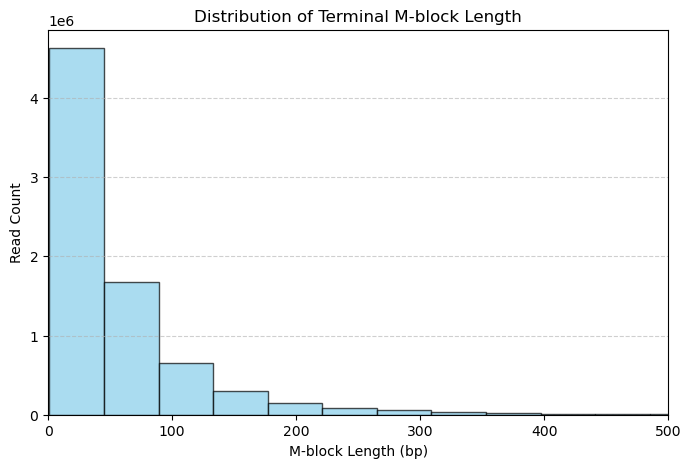

M-block长度统计:
  中位数: 34.0
  平均值: 55.39


In [14]:
# --- 步骤 4: 捕获点所在的M-block长度分布图 ---
plot_m_distribution(df_results)

def plot_m_distribution(df):
    # 关闭所有已存在的图形
    plt.close('all')
    
    plt.figure(figsize=(8, 5))
    plt.hist(df['terminal_m_len'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlim(0, 500)
    plt.title('Distribution of Terminal M-block Length')
    plt.xlabel('M-block Length (bp)')
    plt.ylabel('Read Count')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
    
    print(f"M-block长度统计:")
    print(f"  中位数: {df['terminal_m_len'].median()}")
    print(f"  平均值: {df['terminal_m_len'].mean():.2f}")